# 十字彈片 - ROI Detection

Copyright © 2019 Hsu Shih-Chieh

In [1]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from utils import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss, get_random_data
from timeit import default_timer as timer
#from keras.utils import multi_gpu_model
import os  
import matplotlib.pyplot as plt
from datasets import load_hotmeltyolodata
from utils import overSampling, YOLOV3

os.environ['CUDA_VISIBLE_DEVICES']='0' 

Using TensorFlow backend.
/usr/local/Cellar/python/3.6.5/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [ ]:


def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2, weights_path='model_data/yolo_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [ ]:
##FIXME 這兩個function應該整合到base.py內

def data_generator_wrapper(annotation_lines, batch_size, input_shape, , num_classes):
    def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
        '''data generator for fit_generator'''
        n = len(annotation_lines)
        i = 0
        while True:
            image_data = []
            box_data = []
            for b in range(batch_size):
                if i==0:
                    np.random.shuffle(annotation_lines)
                image, box = get_random_data(annotation_lines[i], input_shape, random=True)
                image_data.append(image)
                box_data.append(box)
                i = (i+1) % n
            image_data = np.array(image_data)
            box_data = np.array(box_data)
            y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
            yield [image_data, *y_true], np.zeros(batch_size)    
    
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)        


### Load Data

In [ ]:
data = load_hotmeltyolodata()
print(data.DESCR)

In [ ]:


lines = data.data
class_names = ['roi']
num_classes = len(class_names)
anchors_str= '10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326'
anchors = np.array([float(x) for x in anchors_str.split(',')]).reshape(-1, 2)

input_shape = (416,416) 

model = create_model(input_shape, anchors, num_classes, freeze_body=2, weights_path='model/yolov3_weights.h5') # make sure you know what you freeze

#logging = TensorBoard(log_dir=log_dir)
#checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5', monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

val_split = 0.1

np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

#model = multi_gpu_model(model, gpus=2)
model.compile(optimizer=Adam(lr=1e-3), loss={
    'yolo_loss': lambda y_true, y_pred: y_pred})

batch_size = 7
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
        steps_per_epoch=max(1, num_train//batch_size),
        validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
        validation_steps=max(1, num_val//batch_size),
        epochs=25,
        initial_epoch=0,
        callbacks=[reduce_lr, early_stopping])
#model.save_weights('model/hotmelt_yolov3weight_tmp.h5')

for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
print('Unfreeze all of the layers.')
batch_size = 7 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=50,
    initial_epoch=25,
    callbacks=[early_stopping, reduce_lr])
model.save_weights('model/hotmelt_yolov3weight.h5')



### Testing

In [2]:
from datasets import load_hotmelt
from PIL import Image, ImageFont, ImageDraw
data = load_hotmelt()

Found 1146 images belonging to 5 classes.


In [6]:
yolo=YOLOV3()

model/hotmelt_yolov3weight.h5 model, anchors, and classes loaded.


(-0.5, 223.5, 223.5, -0.5)

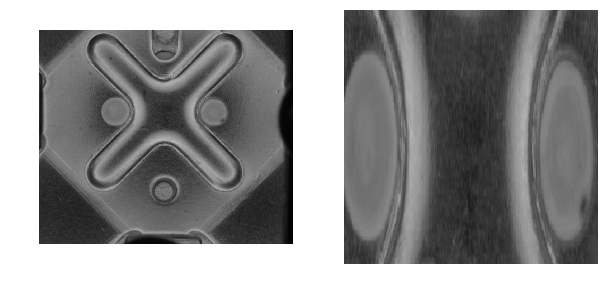

In [33]:
roi = yolo.predict_roi(Image.fromarray(data.data[0]))
plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(data.data[0])
plt.axis('off')
plt.subplot(122)
plt.imshow(roi)
plt.axis('off')